# Model Evaluation

We'll be using the Thyroid Disease dataset, a famous dataset of patients diagnosed as positive or negative for hypothyroidism, a medical condition. The dataset has 21 features and several thousand instances. More information on the data can be found here: http://archive.ics.uci.edu/ml/datasets/thyroid+disease.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

Let's begin by loading the data and separating the features and class.

In [2]:
url = 'https://raw.githubusercontent.com/cse44648/cse44648/master/datasets/hypothyroid.csv'

df = pd.read_csv(url)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [3]:
y.value_counts()

negative       3012
hypothyroid     151
Name: Class, dtype: int64

Let's now preprocess the data so that we can apply different classification models. We'll impute missing values, "dummify" nominal features, and encode the class values as numeric labels.

In [4]:
def impute(X):
    # Initialize an Imputer with the appropriate imputation strategy.
    imp = SimpleImputer(strategy='mean')
    for col in X.select_dtypes(include=['float64']).columns:
        # Fit the imputer and transform/impute the feature.
        imputed_X = imp.fit_transform(X[col].values.reshape(-1, 1))

        # Replace the original feature values with the imputed values.
        imputed_X = pd.DataFrame(imputed_X, columns=[col])
        X[col] = imputed_X
    return X

def dummify(X):
    # Encode nominal features with indicator/dummy variables.
    dummy_cols = [X.columns[i] for i, tp in enumerate(X.dtypes)
                  if tp == 'object']
    for col in dummy_cols:
        temp = pd.get_dummies(X[col], prefix=col)
        X = pd.concat([X, temp], axis=1).drop(col, axis=1)
    return X

def encode(y): 
    # Encode and transform class values to numeric type.
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y).astype(int)
    y = pd.Series(y, name=df.columns[-1])
    return y

X = impute(X)
X = dummify(X)
y = encode(y)

### Performance Measurements: Accuracy and AUROC

Now let's apply some classification models and examine their performance. We'll evaluate the models according to their accuracy and their area under the receiver operating characteristic (ROC) curve, also known as the AUROC.

In [5]:
clfs = [DecisionTreeClassifier(),
        KNeighborsClassifier(n_neighbors=5),
        LogisticRegression(solver='lbfgs', max_iter=1000),
        Perceptron(tol=1e-3)]

n_splits = 10
for i, clf in enumerate(clfs):
    skf_acc = 0.
    skf_auc = 0.

    skf = StratifiedKFold(n_splits=n_splits, random_state=i)
    for train_index, test_index in skf.split(X, y):
        # Split the data into training and testing sets.
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model and get predictions.
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Calculate and sum the accuracy and AUC scores.
        skf_acc += accuracy_score(y_test, y_pred)
        skf_auc += roc_auc_score(y_test, y_pred)

    # Get the mean accuracy and AUC scores.
    skf_acc = round(skf_acc / n_splits, 3)
    skf_auc = round(skf_auc / n_splits, 3)

    # Get the classifier name.
    clf_name = str(type(clf)).split('.')[-1][:-2]

    print("{} \n\tAcc: {}\n\tAUC: {}\n".format(clf_name, skf_acc, skf_auc))

DecisionTreeClassifier 
	Acc: 0.985
	AUC: 0.92

KNeighborsClassifier 
	Acc: 0.984
	AUC: 0.879

LogisticRegression 
	Acc: 0.981
	AUC: 0.858

Perceptron 
	Acc: 0.978
	AUC: 0.851



### ROC Curves

Let's examine the ROC metric in more detail. Instead of simply calculating the area, a single value, let's look at the actual curve for each model. This will allow us to examine how the performance of the classifiers differ at specific different true positive rates (TPR) and false positive rates (FPR).

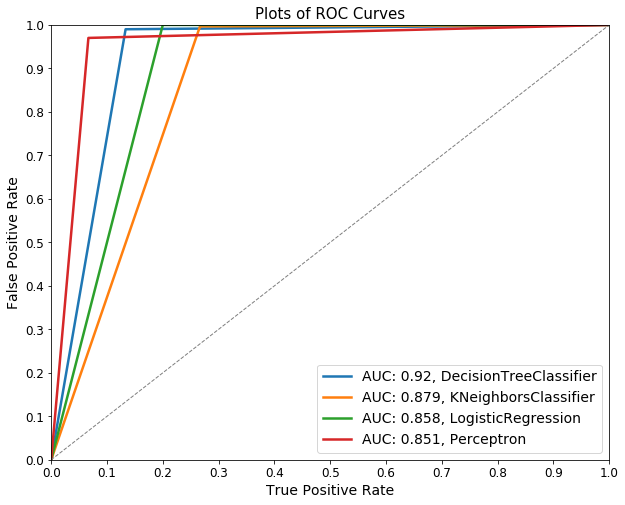

In [6]:
plt.figure(figsize=(10, 8))

n_splits = 10
for i, clf in enumerate(clfs):
    skf_auc = 0.

    skf = StratifiedKFold(n_splits=n_splits, random_state=i)
    for train_index, test_index in skf.split(X, y):
        # Split the data into training and testing sets.
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model and get predictions.
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Calculate and sum the AUC score.
        skf_auc += roc_auc_score(y_test, y_pred)

    # Get the mean AUC score.
    skf_auc = round(skf_auc / n_splits, 3)

    # Get the classifier name.
    clf_name = str(type(clf)).split('.')[-1][:-2]

    # Get FPR, TPR, and corresponding thresholds.
    fpr, tpr, thresh = roc_curve(y_test, y_pred)

    # Plot the ROC curve.
    plt.plot(fpr, tpr, linewidth=2.5,
             label="AUC: {}, {}".format(skf_auc, clf_name))

# Plot baseline.
plt.plot([0, 1], [0, 1], '--', linewidth=1, color='gray')

# Specify plot details.
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=12)
plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=12)
plt.xlabel("True Positive Rate", fontsize=14)
plt.ylabel("False Positive Rate", fontsize=14)
plt.yticks(fontsize=12)
plt.legend(loc=0, fontsize=14)
plt.title("Plots of ROC Curves", fontsize=15);